## 참조 사이트 : https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html

In [36]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10824254.01it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 174813.75it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:07<00:00, 568655.91it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20048539.45it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [37]:
# 디바이스를 cuda, cpu
# macos사용자는 아래의 코드 참조
#device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
device = "cuda" if torch.cuda.is_available() else "cpu"

In [39]:
from torchvision import transforms

# 이미지를 정규화(Normalize) : 0~255 uint8 -> 0~1사이의 float
transform = transforms.Compose([
    transforms.ToTensor(),
    # 평균, 표준편차
    transforms.Normalize((0.2860,), (0.3530,))
])

In [40]:
train_ratio = 0.8

train_size = int(len(training_data)*0.8)
valid_size = len(training_data) - train_size

print(train_size, valid_size)

48000 12000


In [41]:
from torch.utils.data import random_split

#random_split으로 데이터 나누기
train_dataset, valid_dataset = random_split(training_data, [train_size, valid_size])

In [42]:
from torch.utils.data import DataLoader

batch_size =64

# 데이터 로더에 넣기
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [43]:
#
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [48]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

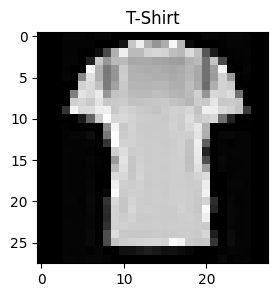

In [55]:
# 이미지를 시각화
# batch_size=64라서 0~63번 index중에 한장을 선택해서 시각화
import random

idx = random.randint(0,63)
plt.figure(figsize=(3,3))
plt.imshow(images[idx].squeeze(), cmap='gray')
plt.title(labels_map[labels[idx].item()])
plt.show()

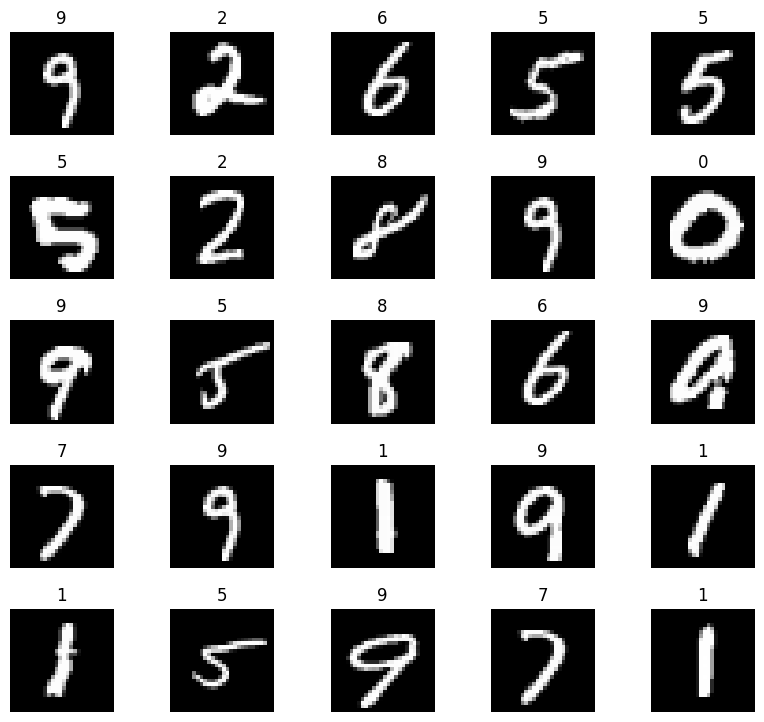

In [10]:
# nxn으로 이미지를 출력
n = 5

fig = plt.figure(figsize=(10, 10))

for i in range(n * n):
    idx = random.randint(0, 63)
    plt.subplot(n, n, i + 1)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.title(labels[idx].item())
    plt.axis('off')

# 하단 공간을 늘리기 위해 추가
plt.subplots_adjust(hspace=0.4, bottom=0.2)

plt.show()

In [11]:
from collections import Counter

labels = training_data.targets  # train_dataset.targets에 라벨 정보가 저장됨


# 고유한 클래스와 갯수 확인
class_count = Counter(labels.numpy())
num_classes = len(class_count)

print(f"MNIST 데이터셋의 클래스 수: {num_classes}")
print(f"각 클래스별 이미지 개수: {class_count}")

MNIST 데이터셋의 클래스 수: 10
각 클래스별 이미지 개수: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [12]:
# 신경망을 구성
# 신경망 모델 정의
inputNode = 28*28  # 이미지의 픽셀 갯수
hiddenNode1 = 512
hiddenNode2 = 256
outputNode = 10 #(0~9)

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # 입력 레이어 -> 첫 번째 중간 레이어
        self.fc2 = nn.Linear(512, 256)      # 첫 번째 중간 레이어 -> 두 번째 중간 레이어
        self.fc3 = nn.Linear(256, 10)       # 두 번째 중간 레이어 -> 출력 레이어 (10개 클래스)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 입력 이미지를 일렬로 펴서 28*28=784 크기의 벡터로 변환
        x = F.relu(self.fc1(x))  # 첫 번째 중간 레이어에서 ReLU 활성화 함수 적용
        x = F.relu(self.fc2(x))  # 두 번째 중간 레이어에서 ReLU 활성화 함수 적용
        x = self.fc3(x)          # 출력 레이어
        return x

In [28]:
lr = 0.001

# 훈련
# 가속을 위해 신경망을 GPU에서 구성
model = Net().to(device)
# 다중 분류를 위한 손실계산 함수
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [29]:
train_loss_list=[]
valid_loss_list=[]
train_acc_list=[]
valid_acc_list=[]

In [30]:
def train(dataloader, model, loss_fn, optimizer):
    train_correct =0
    train_total =0

    # 신경망의 모드를 훈련모드로 설정
    model.train()

    # 매 batch마다 loss를 누적
    train_loss = 0.0

    # batch사이즈만큼 이미지와 레이블을 가져와서
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 기울기 0으로 초기화
        optimizer.zero_grad()

        # 이미지로 추론해서 예측값 출력
        y_pred = model(images)

        # 손실값 계산
        loss = loss_fn(y_pred, labels)
        # 오차 역전파법으로 경사하강법, 기울기 구하기
        loss.backward()

        # 실제 W,b값 업데이트하기
        optimizer.step() # W_new = W_old - lr*grad(w)

        _, predicted = torch.max(y_pred.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # loss값 누적하기
        train_loss += loss.item()

    train_loss_list.append(train_loss)
    train_acc = (train_correct/train_total)*100
    train_acc_list.append(train_acc)

    return train_loss

In [31]:
def valid(dataloader, model, loss_fn):
    # 신경망의 모드를 평가모드로 설정
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    # 기울기를 구하지 않는다.
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            y_pred = model(images)
            loss = loss_fn(y_pred, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss_list.append(valid_loss)
    valid_acc = (correct/total)*100
    valid_acc_list.append(valid_acc)

    accuracy = 100 * correct / total
    return valid_loss, accuracy

In [32]:
epochs = 20

for epoch in range(epochs):
    # 매 epoch마다 파라메터(가중치) 학습
    train_loss = train(train_loader, model, loss_fn, optimizer)
    # 매 epoch마다 loss값을 출력
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss / len(train_loader)}")

    valid_loss, val_acc = valid(valid_loader, model, loss_fn)
    print(f"Valid Loss: {valid_loss / len(valid_loader)}, Accuracy: {val_acc}%")

Epoch 1/20, Train Loss: 0.2719261289897064
Valid Loss: 0.13250562005696145, Accuracy: 95.88333333333334%
Epoch 2/20, Train Loss: 0.09912400073123474
Valid Loss: 0.09478800846362843, Accuracy: 97.075%
Epoch 3/20, Train Loss: 0.06452087888121605
Valid Loss: 0.07700251794836306, Accuracy: 97.58333333333333%
Epoch 4/20, Train Loss: 0.046441912858436504
Valid Loss: 0.08809642974990717, Accuracy: 97.33333333333333%
Epoch 5/20, Train Loss: 0.034064534148046124
Valid Loss: 0.08421906720391138, Accuracy: 97.65%
Epoch 6/20, Train Loss: 0.02569471518008504
Valid Loss: 0.0978412482924041, Accuracy: 97.35%
Epoch 7/20, Train Loss: 0.02126743983842122
Valid Loss: 0.0884682219785123, Accuracy: 97.775%
Epoch 8/20, Train Loss: 0.02046855639500427
Valid Loss: 0.09765571814034743, Accuracy: 97.66666666666667%
Epoch 9/20, Train Loss: 0.014415197733326446
Valid Loss: 0.10779034856928542, Accuracy: 97.50833333333334%
Epoch 10/20, Train Loss: 0.016835546106119485
Valid Loss: 0.08917229153427043, Accuracy: 97.

In [33]:
len(train_loss_list)

20

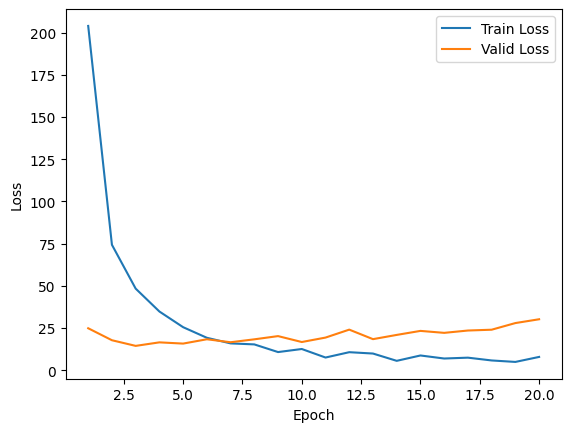

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1,epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1,epochs+1), valid_loss_list, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

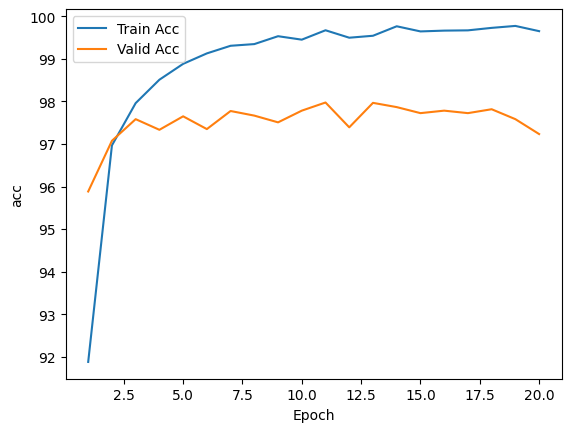

In [35]:
plt.figure()
plt.plot(range(1,epochs+1), train_acc_list, label='Train Acc')
plt.plot(range(1,epochs+1), valid_acc_list, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.legend()
plt.show()